In [1]:
import struct
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import csv
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path

In [2]:
video_name = "summary_e619a81ff91bcf8ebc69d0763ab32681#201008230800.avi"
txt_name = "e619a81ff91bcf8ebc69d0763ab32681#201008230800.txt"
csv_name = "data_siteHoBiHu_camera1_201008230800.csv"
npy_name = "e619a81ff91bcf8ebc69d0763ab32681#201008230800.RESULT.npy"
yhat_name = "e619a81ff91bcf8ebc69d0763ab32681#201008230800.YHAT.npy"
frame_info_name = "frame_info_e619a81ff91bcf8ebc69d0763ab32681#201008230800.txt"

In [18]:
# create a dataframe from csv file
def create_frame(file):
    df = pd.read_csv(file)
    return df

# create readable structure from txt file
def create_frame_info(fi_name):
    with open(fi_name) as f:
        frame_info = f.readlines()
    return frame_info

# create a list of ids present in a readable structure
def get_ids_from_txt(frame_info):
    ids = []
    for line in frame_info:
        a, rest = line.split(",", 1)
        ids.append(int(a))
    return(ids)

# get IDs from dataframe
def get_ids_from_frame(frame):
    return frame['detection_id'].tolist()

#get set difference
def get_difference(a, b):
    return list(set(a).difference(set(b)))

def remove_rows(dframe, idlist):
    dframe = dframe.set_index("detection_id")
    dframe = dframe.drop(idlist, axis=0)
    return dframe

def clean_csv(csvfile, fifile):
    dframe = create_frame(csvfile)
    print("Created dataframe with {:d} rows.".format(dframe.shape[0]))
    frame_info = create_frame_info(fifile)
    print("Created frameinfo file with {:d} rows.".format(len(frame_info)))
    csvids = get_ids_from_frame(dframe)
    fiids = get_ids_from_txt(frame_info)
    diff = get_difference(csvids, fiids)
    final_frame = remove_rows(dframe, diff)
    print("Removed {:d} rows from dataframe. Final row count is {:d}.".format(len(diff), final_frame.shape[0]))
    return final_frame

def create_npy_array(npy_file):
    return np.load(npy_file)

# get all points from a contour and store as a list of tuples
def get_contour_points(contour):
    cont = contour[2:-1]
    tuples = cont.split(";")
    l = []
    for item in tuples:
        a, b = item.split(" ")
        l.append((int(a), int(b)))
    return l

# gets all contours form a dataframe. We can conveniently traverse this using detection id
def get_contours(dataframe):
    return dataframe[' contour']

def process_batch(csvname, finame, npyname, vname):
    a = clean_csv(csvname, finame)
    truths = create_npy_array(npyname)
    idx = get_frames_with_fish(vname, truths, a)
    b = remove_rows_by_index(a, idx)
    print("Kept {:d} lines based on npy T/F.".format(b.shape[0]))
    return b

def get_frames_with_fish(vname, npy, dframe):
    vidcap = cv2.VideoCapture(vname)
    success,image = vidcap.read()
    count = 0
    rows_to_remove = []
    frame = 0
    while success:
        if (npy[count]):
            cv2.imwrite("frame%d.jpg" % frame, image)     # save frame as JPG file
            frame+= 1
        else:
            rows_to_remove.append(count)
        success,image = vidcap.read()
        count += 1
    return rows_to_remove

def remove_rows_by_index(dframe, idxlist):
    return dframe.drop(dframe.index[idxlist])
   
def get_points_from_contour(contour):
    cont = contour[2:-1]
    tuples = cont.split(";")
    final = []
    for item in tuples:
        (x, y) = item.split(" ")
        print(x,y)
        final.append([(x, y)])
    return final

def get_frame_count(video):
    vidcap = cv2.VideoCapture(video)
    success, image = vidcap.read()
    count = 0
    while success:
        success, image = vidcap.read()
        count += 1
    return count

def get_metadata(dframe):
    df = pd.DataFrame(columns=[' fish_id', ' video_id', ' bounding_box_x', ' bounding_box_y', ' specie_id', 
                               ' contour'])
    indices = dframe.index.tolist()
    for i, idx in enumerate(indices):
        row = dframe.loc[idx]
        fid = row[' fish_id']
        vid = row[' video_id']
        bbx = row[' bounding_box_x']
        bby = row[' bounding_box_y']
        sid = row[' specie_id']
        contour = row[' contour']
        df.loc[idx] = [fid, vid, bbx, bby, sid, contour]
        
    return df

def process_image(img_name, x, y, cont_points):
    img = cv2.imread(img_name)
    mask = np.zeros((100,100))
    xdiff = x - 10
    ydiff = y - 10
    xs = []
    ys = []
    for (a,b) in cont_points:
        v = a - xdiff
        u = b - ydiff
        xs.append(u)
        ys.append(v)
        img[u,v] = (0,0,255)
        mask[u,v] = 1
    return img, mask, xs, ys

def produce_RGB_nRGB_avgs(shrunk_csv):
    indices = shrunk_csv.index.tolist()
    dframe = pd.DataFrame(columns=["B", "G", "R", "nB", "nG", "nR"])
    for idx, l in enumerate(indices):
        # create contour points
        contour = get_contour_points(shrunk_csv.loc[l][5])
        # get bb starting point
        x = shrunk_csv.loc[l][2]
        y = shrunk_csv.loc[l][3]
        # set name to pick correct image
        imgname = "frame"+str(idx)+".jpg"
        # process image
        img, mask, xs, ys = process_image(imgname, x, y, contour)
        # get average x and y coordinate of boundary
        plt.imshow(img)
        plt.show()
        xavg = int(np.mean(xs))
        yavg = int(np.mean(ys))
        # set coordinates for CoM point
        startpoint = (xavg, yavg)
        # compute CoM-based shape
        com(img, startpoint, mask)
        # extract specific channels
        channel0 = img[:,:,0]
        channel1 = img[:,:,1]
        channel2 = img[:,:,2]
        # compute averages
        c0avg = np.mean(mask*channel0)
        c1avg = np.mean(mask*channel1)
        c2avg = np.mean(mask*channel2)
        # compute normalized image
        normRGB = normalizedRGB(img)
        # extract normalized RGB channels
        normc0 = normRGB[:,:,0]
        normc1 = normRGB[:,:,1]
        normc2 = normRGB[:,:,2]
        # compute averages
        normc0avg = np.mean(mask*normc0)
        normc1avg = np.mean(mask*normc1)
        normc2avg = np.mean(mask*normc2)
        # save to dataframe
        dframe.loc[l] = [c0avg, c1avg, c2avg, normc0avg, normc1avg, normc2avg]
        
    vid = shrunk_csv.loc[l][1] + ".csv"
    dframe.to_csv(vid)
    return dframe

def normalizedRGB(img):
    newimg=np.zeros((img.shape))
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            b,g,r = col
            s = b+g+r
            newimg[i,j] = (b//s), (g//s), (r//s)
    return newimg        

def com(img, startpoint, mask):
    (xavg, yavg) = startpoint
    
    nextleft = (xavg, yavg-1)
    nextright = (xavg, yavg+1)
    nextup = (xavg+1, yavg)
    nextdown = (xavg-1, yavg)
    
    if (mask[nextleft]==0):
        mask[nextleft] = 1
        com(img, nextleft, mask)
    if (mask[nextright]==0):
        mask[nextright] = 1
        com(img, nextright, mask)
    if (mask[nextup]==0):
        mask[nextup] = 1
        com(img, nextup, mask)
    if (mask[nextdown]==0):
        mask[nextdown] = 1
        com(img, nextdown, mask)

In [4]:

def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [6]:
path_to_csvs = "/media/sam/Sam\'s Drive/SUBSET/SQL/ALLYEARS/"
mypath = "/media/sam/Sam\'s Drive/SUBSET/SQL/ALLYEARS"

csvnames = [f for f in listdir(mypath) if isfile(join(mypath, f))]


In [ ]:
donecount = 0
for i, name in enumerate(csvnames):
    try:
        full_path_and_name = path_to_csvs + name
        df = pd.read_csv(full_path_and_name)
        videoID = df.iloc[0][4][1:]
        video_name_fix = "summary_" + videoID + ".avi"
        npy_name_fix = videoID + ".RESULT.npy"
        frame_info_fix = "frame_info_" + videoID + ".txt"
        videos_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/f4k_extracted_image/output/summaries/"
        frame_info_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/f4k_extracted_image/output/summaries/"
        npy_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/final/"
        video_path = find(video_name_fix, videos_dir)
        frame_info_path = find(frame_info_fix, frame_info_dir)
        npy_path = find(npy_name_fix, npy_dir)
        full_df = process_batch(full_path_and_name, frame_info_path, npy_path, video_path)
        metadata = get_metadata(full_df)
        produce_RGB_nRGB_avgs(metadata)
        donecount += 1
        diff = (i+1-donecount)
        # delete frames
        for p in Path(".").glob("frame*.jpg"):
            p.unlink()
        print(videoID, " done. So far skipped ", diff, " videos.")
    except TypeError:
        continue
    except IndexError:
        continue

In [ ]:
for item in csvnames:
    print (item)

Created dataframe with 94 rows.
Created frameinfo file with 94 rows.
Removed 0 rows from dataframe. Final row count is 94.
Kept 79 lines based on npy T/F.


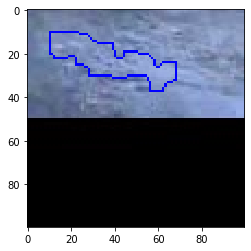

/home/sam/anaconda3/envs/mlp/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: overflow encountered in ubyte_scalars
/home/sam/anaconda3/envs/mlp/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in ubyte_scalars


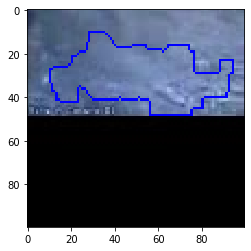

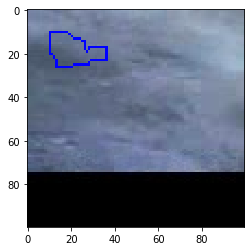

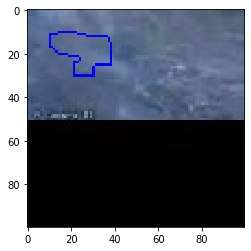

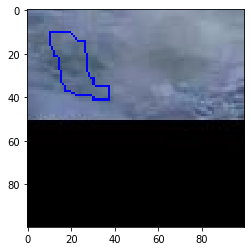

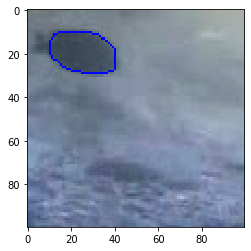

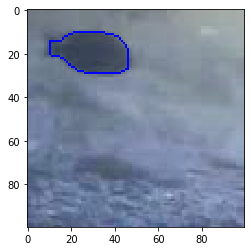

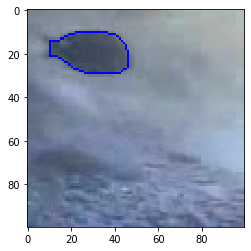

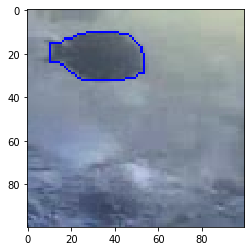

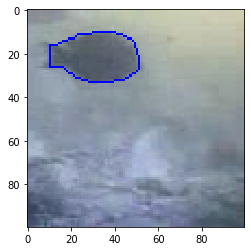

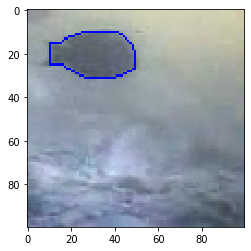

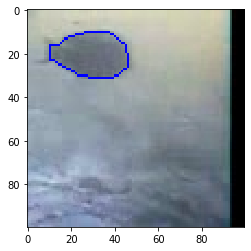

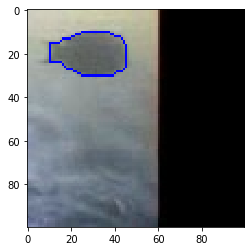

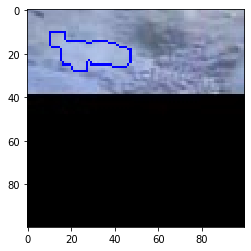

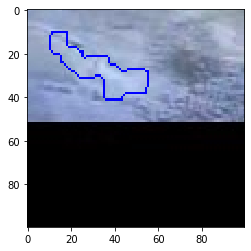

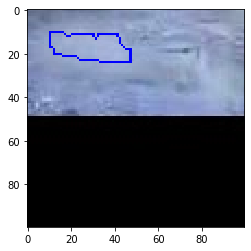

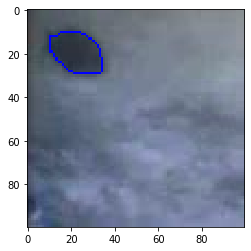

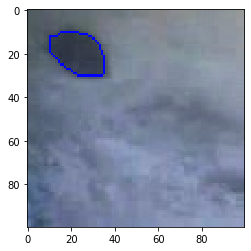

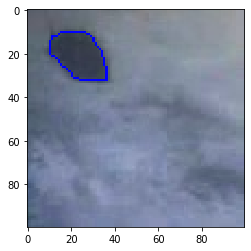

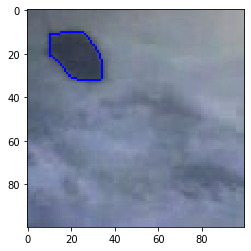

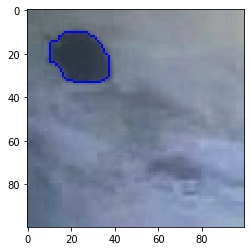

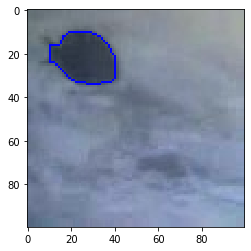

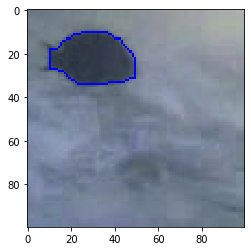

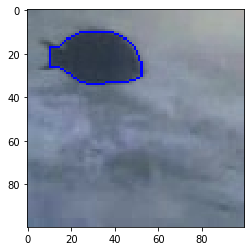

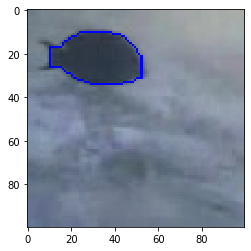

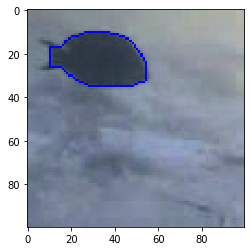

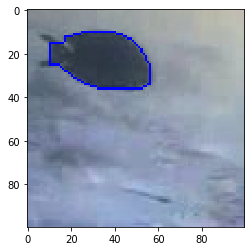

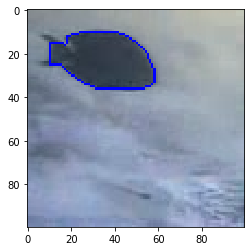

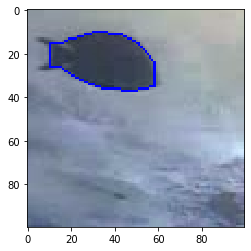

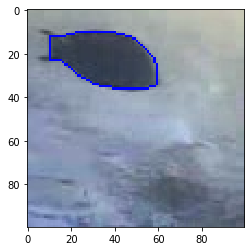

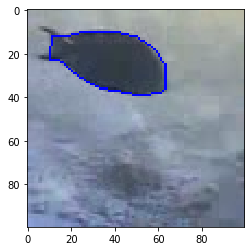

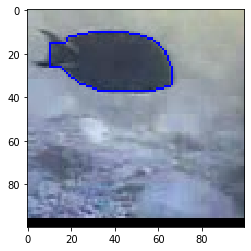

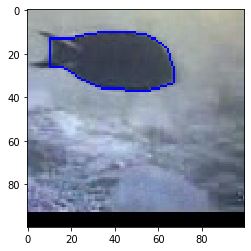

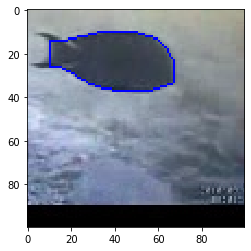

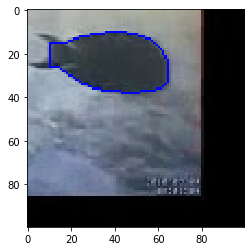

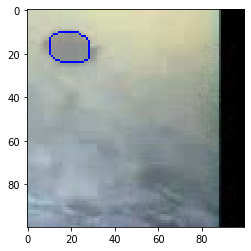

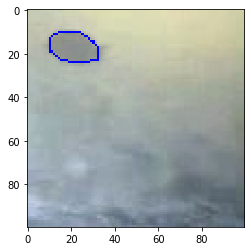

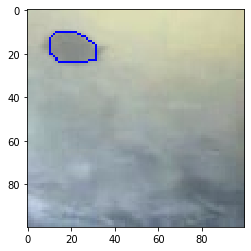

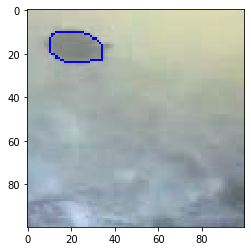

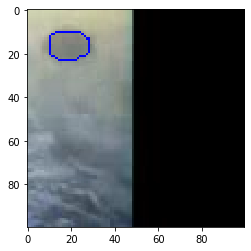

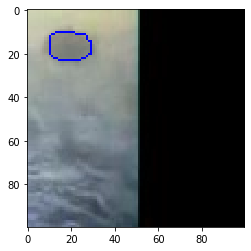

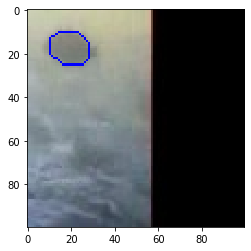

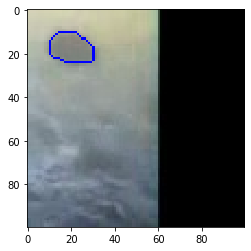

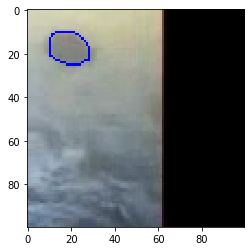

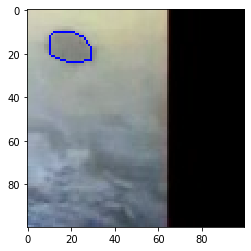

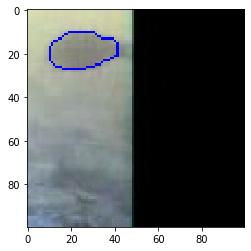

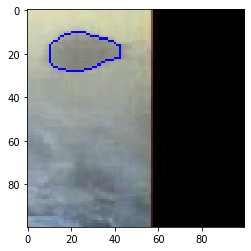

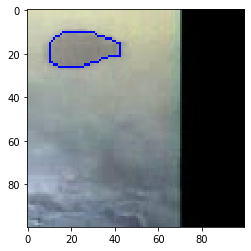

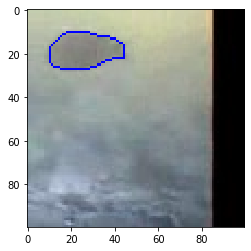

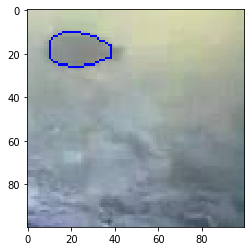

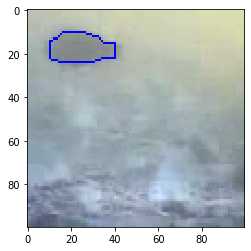

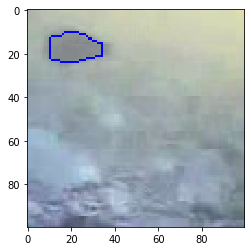

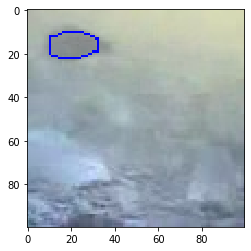

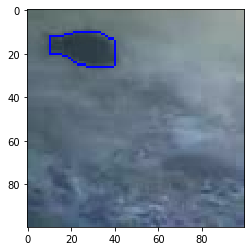

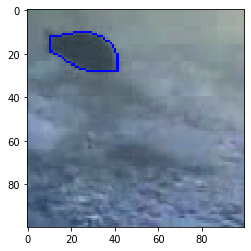

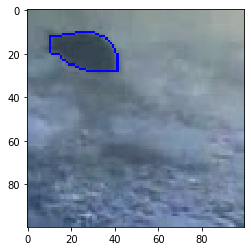

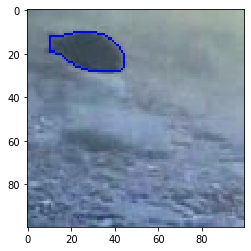

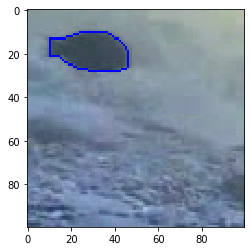

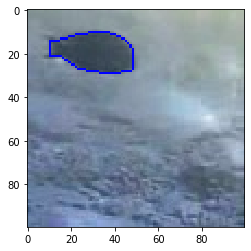

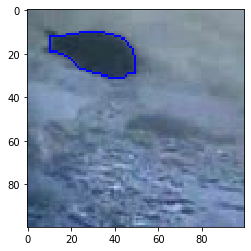

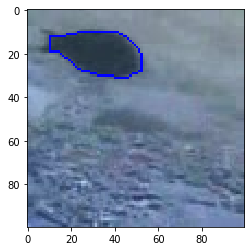

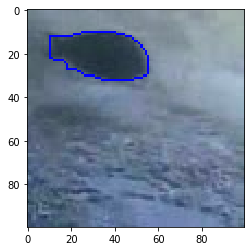

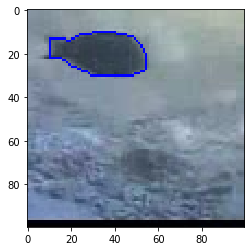

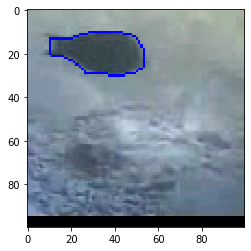

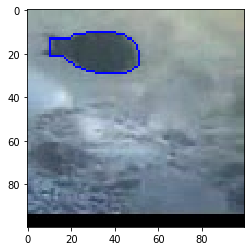

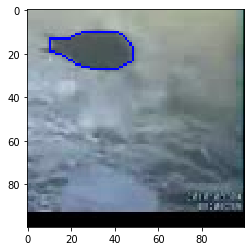

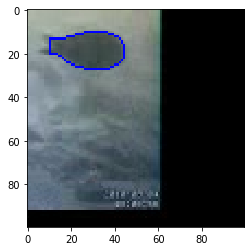

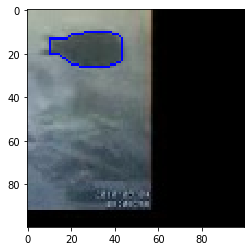

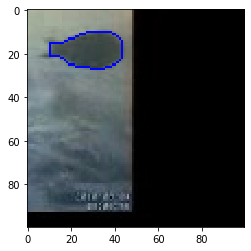

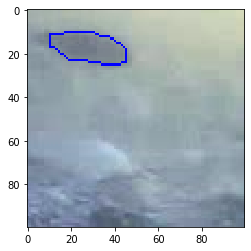

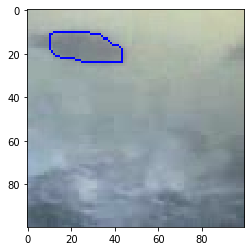

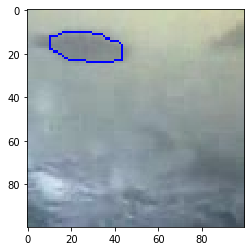

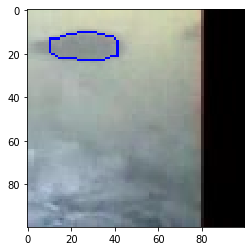

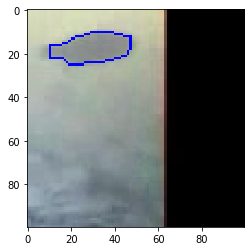

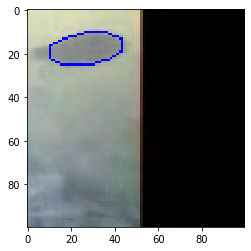

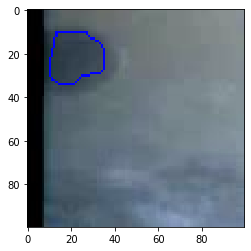

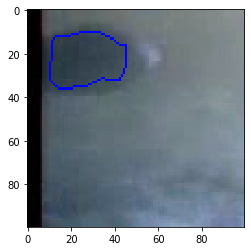

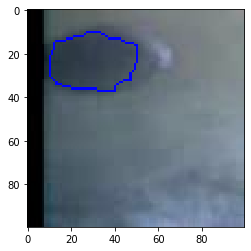

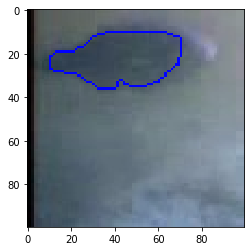

a14156f36c3cb7feef8fb65de2cd26c2#201009040800  done.


In [41]:
line = csvnames[8]
full_path_and_name = path_to_csvs + line
df = pd.read_csv(full_path_and_name)
videoID = df.iloc[0][4][1:]
video_name_fix = "summary_" + videoID + ".avi"
npy_name_fix = videoID + ".RESULT.npy"
frame_info_fix = "frame_info_" + videoID + ".txt"
videos_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/f4k_extracted_image/output/summaries/"
frame_info_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/f4k_extracted_image/output/summaries/"
npy_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/final/"
video_path = find(video_name_fix, videos_dir)
frame_info_path = find(frame_info_fix, frame_info_dir)
npy_path = find(npy_name_fix, npy_dir)
full_df = process_batch(full_path_and_name, frame_info_path, npy_path, video_path)
metadata = get_metadata(full_df)
produce_RGB_nRGB_avgs(metadata)
# delete frames
for p in Path(".").glob("frame*.jpg"):
    p.unlink()
print(videoID, " done.")

In [13]:
asd = np.load(npy_path)

In [23]:
print(frame_info_path)

None


In [31]:
# to clean the names when we don't have the files
for i, name in enumerate(csvnames):
    full_path_and_name = path_to_csvs + name
    df = pd.read_csv(full_path_and_name)
    videoID = df.iloc[0][4][1:]
    video_name_fix = "summary_" + videoID + ".avi"
    npy_name_fix = videoID + ".RESULT.npy"
    frame_info_fix = "frame_info_" + videoID + ".txt"
    videos_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/f4k_extracted_image/output/summaries/"
    frame_info_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/f4k_extracted_image/output/summaries/"
    npy_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/final/"
    video_path = find(video_name_fix, videos_dir)
    frame_info_path = find(frame_info_fix, frame_info_dir)
    npy_path = find(npy_name_fix, npy_dir)
    if (npy_path==None):
        print("Removed {:s} from list.".format(name))
        csvnames.remove(name)
    elif (video_path==None):
        print("Removed {:s} from list.".format(name))
        csvnames.remove(name)
    elif (frame_info_path==None):
        print("Removed {:s} from list.".format(name))
        csvnames.remove(name)
    if (i % 10 == 0):
        print("{:d} items done.".format(i))

0 items done.
10 items done.
Removed data_siteNPP-3_camera1_201203280800.csv from list.
Removed data_siteNPP-3_camera1_201203300800.csv from list.
Removed data_siteNPP-3_camera1_201204010800.csv from list.
Removed data_siteNPP-3_camera1_201204030800.csv from list.
Removed data_siteNPP-3_camera1_201204050800.csv from list.
Removed data_siteNPP-3_camera1_201204120800.csv from list.
20 items done.
Removed data_siteNPP-3_camera1_201204200800.csv from list.
30 items done.
40 items done.
50 items done.
Removed data_siteNPP-3_camera3_201006200800.csv from list.
Removed data_siteNPP-3_camera3_201007200800.csv from list.
Removed data_siteNPP-3_camera3_201007230800.csv from list.
Removed data_siteNPP-3_camera3_201007260800.csv from list.
60 items done.
Removed data_siteLanYu_camera1_201008060800.csv from list.
70 items done.
Removed data_siteLanYu_camera1_201008080800.csv from list.
Removed data_siteLanYu_camera1_201008160800.csv from list.
80 items done.
Removed data_siteHoBiHu_camera1_20101202

Removed data_siteNPP-3_camera3_201302190800.csv from list.
650 items done.
Removed data_siteNPP-3_camera4_201302150800.csv from list.
660 items done.
Removed data_siteNPP-3_camera4_201302220800.csv from list.
Removed data_siteNPP-3_camera3_201110150800.csv from list.
Removed data_siteNPP-3_camera3_201202280800.csv from list.
670 items done.
Removed data_siteNPP-3_camera1_201112080800.csv from list.
680 items done.
Removed data_siteNPP-3_camera1_201112140800.csv from list.
690 items done.
Removed data_siteNPP-3_camera1_201105290800.csv from list.
700 items done.
710 items done.
Removed data_siteLanYu_camera1_201010180800.csv from list.
720 items done.
Removed data_siteLanYu_camera1_201010230800.csv from list.
730 items done.
Removed data_siteNPP-3_camera4_201103310800.csv from list.
740 items done.
Removed data_siteNPP-3_camera4_201104030800.csv from list.
750 items done.
Removed data_siteNPP-3_camera1_200912310800.csv from list.
760 items done.
Removed data_siteNPP-3_camera1_2010011308

Removed data_siteNPP-3_camera3_201206270800.csv from list.
1350 items done.
Removed data_siteNPP-3_camera3_201206300800.csv from list.
Removed data_siteNPP-3_camera2_201212220800.csv from list.
Removed data_siteNPP-3_camera2_201301020800.csv from list.
1360 items done.
1370 items done.
Removed data_siteNPP-3_camera1_201104180800.csv from list.
1380 items done.
Removed data_siteNPP-3_camera2_201105070800.csv from list.
1390 items done.
Removed data_siteNPP-3_camera1_201205240800.csv from list.
Removed data_siteNPP-3_camera1_201205260800.csv from list.
Removed data_siteNPP-3_camera1_201205310800.csv from list.
Removed data_siteNPP-3_camera1_201206020800.csv from list.
Removed data_siteNPP-3_camera1_201206070800.csv from list.
Removed data_siteNPP-3_camera3_201212040800.csv from list.
1400 items done.
Removed data_siteNPP-3_camera3_201212060800.csv from list.
Removed data_siteNPP-3_camera3_201212080800.csv from list.
Removed data_siteNPP-3_camera3_201212100800.csv from list.
Removed data_

Removed data_siteHoBiHu_camera2_201101040800.csv from list.
Removed data_siteNPP-3_camera2_201202240800.csv from list.
Removed data_siteNPP-3_camera2_201202270800.csv from list.
Removed data_siteNPP-3_camera2_201202290800.csv from list.
2030 items done.
Removed data_siteNPP-3_camera2_201203020800.csv from list.
Removed data_siteNPP-3_camera2_201203040800.csv from list.
Removed data_siteNPP-3_camera2_201203080800.csv from list.
2040 items done.
Removed data_siteNPP-3_camera4_201008240800.csv from list.
2050 items done.
Removed data_siteNPP-3_camera3_201003150800.csv from list.
Removed data_siteNPP-3_camera3_201003180800.csv from list.
2060 items done.
2070 items done.
Removed data_siteNPP-3_camera3_201012040800.csv from list.
2080 items done.
Removed data_siteNPP-3_camera2_201106240800.csv from list.
Removed data_siteNPP-3_camera2_201106260800.csv from list.
2090 items done.
Removed data_siteNPP-3_camera2_201107010800.csv from list.
Removed data_siteNPP-3_camera2_201107030800.csv from l

2620 items done.
Removed data_siteNPP-3_camera1_201008300800.csv from list.
Removed data_siteNPP-3_camera1_201009090800.csv from list.
2630 items done.
Removed data_siteNPP-3_camera1_201103040800.csv from list.
2640 items done.
Removed data_siteNPP-3_camera1_201103180800.csv from list.
2650 items done.
Removed data_siteNPP-3_camera2_201001010800.csv from list.
2660 items done.
Removed data_siteLanYu_camera1_201109170800.csv from list.
2670 items done.
Removed data_siteLanYu_camera1_201109200800.csv from list.
2680 items done.
Removed data_siteLanYu_camera1_201110040800.csv from list.
2690 items done.
Removed data_siteLanYu_camera2_201105130800.csv from list.
Removed data_siteNPP-3_camera3_201105290800.csv from list.
Removed data_siteNPP-3_camera3_201105310800.csv from list.
2700 items done.
Removed data_siteNPP-3_camera3_201106120800.csv from list.
Removed data_siteNPP-3_camera3_201106140800.csv from list.
Removed data_siteNPP-3_camera2_201108060800.csv from list.
Removed data_siteNPP-

Removed data_siteLanYu_camera2_201109120800.csv from list.
3240 items done.
Removed data_siteLanYu_camera1_201104170800.csv from list.
Removed data_siteLanYu_camera1_201104200800.csv from list.
3250 items done.
Removed data_siteNPP-3_camera1_201001270800.csv from list.
3260 items done.
Removed data_siteNPP-3_camera1_201002010800.csv from list.
Removed data_siteNPP-3_camera1_201002030800.csv from list.
Removed data_siteNPP-3_camera4_201306020800.csv from list.
3270 items done.
Removed data_siteNPP-3_camera4_201306130800.csv from list.
Removed data_siteNPP-3_camera4_201307070800.csv from list.
3280 items done.
3290 items done.
3300 items done.
Removed data_siteLanYu_camera2_201103100800.csv from list.
3310 items done.
Removed data_siteLanYu_camera2_201103190800.csv from list.
3320 items done.
3330 items done.
Removed data_siteNPP-3_camera3_201011140800.csv from list.
3340 items done.
Removed data_siteNPP-3_camera2_201005010800.csv from list.
Removed data_siteNPP-3_camera2_201005090800.cs

Removed data_siteNPP-3_camera3_201111250800.csv from list.
3800 items done.
3810 items done.
Removed data_siteNPP-3_camera4_201304200800.csv from list.
3820 items done.
Removed data_siteNPP-3_camera1_201210200800.csv from list.
Removed data_siteNPP-3_camera1_201210240800.csv from list.
Removed data_siteNPP-3_camera1_201210300800.csv from list.
3830 items done.
Removed data_siteLanYu_camera1_201007140800.csv from list.
3840 items done.
Removed data_siteNPP-3_camera2_201009270800.csv from list.
Removed data_siteNPP-3_camera2_201010010800.csv from list.
3850 items done.
Removed data_siteNPP-3_camera2_201010040800.csv from list.
Removed data_siteNPP-3_camera2_201011020800.csv from list.
3860 items done.
Removed data_siteNPP-3_camera2_201012010800.csv from list.
3870 items done.
Removed data_siteNPP-3_camera2_201112130800.csv from list.
3880 items done.
Removed data_siteNPP-3_camera2_201112190800.csv from list.
Removed data_siteNPP-3_camera2_201201170800.csv from list.
3890 items done.
Remo

/home/sam/anaconda3/envs/mlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Removed data_siteNPP-3_camera3_201208240800.csv from list.
4280 items done.
Removed data_siteNPP-3_camera4_201206180800.csv from list.
Removed data_siteLanYu_camera1_201005070800.csv from list.
Removed data_siteLanYu_camera1_201005100800.csv from list.
4290 items done.
Removed data_siteLanYu_camera1_201005180800.csv from list.
Removed data_siteLanYu_camera1_201005210800.csv from list.
4300 items done.
Removed data_siteNPP-3_camera2_201002240800.csv from list.
4310 items done.
Removed data_siteNPP-3_camera1_201011030800.csv from list.
4320 items done.
Removed data_siteNPP-3_camera1_201011110800.csv from list.
4330 items done.
Removed data_siteNPP-3_camera4_201202210800.csv from list.
Removed data_siteNPP-3_camera3_201209170800.csv from list.
Removed data_siteNPP-3_camera3_201209190800.csv from list.
Removed data_siteNPP-3_camera3_201209210800.csv from list.
Removed data_siteNPP-3_camera3_201209230800.csv from list.
4340 items done.
Removed data_siteNPP-3_camera1_201101020800.csv from li

In [30]:
print(20%10)

0


In [32]:
print(len(csvnames))

4521


In [33]:
type(csvnames)

list

In [34]:
with open('csvnames.txt', 'w') as f:
    for item in csvnames:
        f.write("%s\n" % item)

In [ ]:
for line in csvnames:
    full_path_and_name = path_to_csvs + line
    df = pd.read_csv(full_path_and_name)
    videoID = df.iloc[0][4][1:]
    video_name_fix = "summary_" + videoID + ".avi"
    npy_name_fix = videoID + ".RESULT.npy"
    frame_info_fix = "frame_info_" + videoID + ".txt"
    videos_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/f4k_extracted_image/output/summaries/"
    frame_info_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/f4k_extracted_image/output/summaries/"
    npy_dir = "/media/sam/My Passport/FISH4KNOWLEDGE/final/"
    video_path = find(video_name_fix, videos_dir)
    frame_info_path = find(frame_info_fix, frame_info_dir)
    npy_path = find(npy_name_fix, npy_dir)
    full_df = process_batch(full_path_and_name, frame_info_path, npy_path, video_path)
    metadata = get_metadata(full_df)
    produce_RGB_nRGB_avgs(metadata)
    # delete frames
    for p in Path(".").glob("frame*.jpg"):
        p.unlink()
    print(videoID, " done.")